# Problem Set 2

#### Abram and Higbee - IO 2, 2021

### Set up environment

In [1]:
# Set wd
pwd()
dir = "/Users/JoshuaHigbee/Box/2. Second Year/2. Winter Quarter - 2021/" *
      "Industrial Organization II - Hortacsu/Problem Sets/Problem Set 2/";
cd(dir);

# Set up packages (must have pre-loaded)
using CSV, DataFrames, Random, Distributions, LinearAlgebra,
      LatexPrint, StatsBase, Plots, SpecialFunctions
using Optim, ForwardDiff, PyCall, ShiftedArrays, StatsPlots

# Set seed
Random.seed!(12345);

# Set column view
ENV["COLUMNS"]=500;

<br><br><br><br>

## QUESTION 1.3

### 1.3.2 - Bayes-Nash Equilibria

Given the shape of the best response functions, and the fact that there are two players, there are at most 3 equilibria for any value of $x$.  First, we verify this using a grid search over parameters, then we use Newton's method to speed up the process and achieve more precision.

##### Grid search for intersections

In [2]:
# Search grid of starting values for equilibria
fxp_eq_grid = (0:1e7) / 1e7

# BR function (vector)
br_eq_vec = function(; α, δ, x, p)
    return exp.(Ref(α*x) .- δ*p) ./ (Ref(1) .+ exp.(Ref(α*x) .- δ*p))
end

# Check equilibria
check_eq_vec = function(; α, δ, x)
    eq_check = DataFrame(p = fxp_eq_grid)
    eq_check.p1 = br_eq_vec(α=α, δ=δ, x=x, p=br_eq_vec(α=α, δ=δ, x=x, p=eq_check.p))
    eq_check.diff = (abs.(eq_check.p .- eq_check.p1) .> 1e-7)
    p1_eq = unique(round.(eq_check[eq_check.diff .== 0, :p], digits=3))
    return hcat(round.(p1_eq, digits=3), round.(br_eq_vec(α=α, δ=δ, x=x, p=p1_eq), digits=3))
end

# Check equilibria for each combination of parameters and x values
println(check_eq_vec(α=1, δ=1, x=1))
println(check_eq_vec(α=1, δ=1, x=2))
println(check_eq_vec(α=3, δ=6, x=1))
println(check_eq_vec(α=3, δ=6, x=2))

[0.599 0.599]
[0.773 0.773]
[0.071 0.929; 0.5 0.5; 0.929 0.071]
[0.712 0.849; 0.785 0.784; 0.849 0.712]


##### Newton's method

In [3]:
# BR function (vector)
br_eq_vec = function(; α, δ, x, p)
    return (exp.(α*x .- δ*p) ./ (Ref(1) .+ exp.(α*x .- δ*p)))
end

# FXP function
fxp_eq_f = function(; α, δ, x, p)
    return p .- reverse(br_eq_vec(α=α, δ=δ, x=x, p=p))
end

# dFXP function
fxp_eq_df = function(; α, δ, x, p)
    dp1dp2 = -(δ*exp.(δ*p[2] .+ α*x))./(exp.(δ*p[2]) .+ exp.(α*x))^2
    dp2dp1 = -(δ*exp.(δ*p[1] .+ α*x))./(exp.(δ*p[1]) .+ exp.(α*x))^2
    return I - [0 dp1dp2; dp2dp1 0]
end

# Newton function
fxp_eq = function(; α, δ, x, p)
    diff = 1; p0=p; p1=p; iter=1
    while diff > 1e-6 && iter < 20
        p1 = p0 .- fxp_eq_df.(α=α, δ=δ, x=x, p=p0)\fxp_eq_f.(α=α, δ=δ, x=x, p=p0)
        diff = maximum(abs.(p1 .- p0))
        p0 = p1; iter=iter+1
    end
    return p1
end


# Save strategy values for use later
θ_vec = [[1,1], [3,6]]
eq_vec = Array{Array{Float64}}(undef, 2, 2)
for x in 1:2
    for i in 1:2
        h_1 = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[1; 0]) # 1 plays high prob
        sym = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[0.5; 0.5]) # Symmetric
        l_1 = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[0; 1]) # 2 plays low prob
        eq_vec[x,i] = [h_1 sym l_1]'
    end
end

# x=1
println(round.(eq_vec[1,1], digits=3)) # α=1, δ=1
println(round.(eq_vec[1,2], digits=3)) # α=3, δ=6

# x=2
println(round.(eq_vec[2,1], digits=3)) # α=1, δ=1
println(round.(eq_vec[2,2], digits=3)) # α=3, δ=6

[0.599 0.599; 0.599 0.599; 0.599 0.599]
[0.929 0.071; 0.5 0.5; 0.071 0.929]
[0.773 0.773; 0.773 0.773; 0.773 0.773]
[0.849 0.712; 0.785 0.785; 0.712 0.849]


<br><br><br><br><br>

### 1.3.3 - Symetric Strategy Estimation

We now use the Newton's method approach to estimate the strategies within the maximum likelihood estimation.

##### Set up simulation data

In [4]:
# Set up parameters
α=3; δ=6;
T=1000; S=50;

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
#dt.x = rand(Binomial(1,0.5), S*T) .+ Ref(1.0) # Testing with drawing x each iteration - - - - - - - - - - - - 
dt.ϵ_1 = rand(Logistic(0,1),S*T)
dt.ϵ_2 = rand(Logistic(0,1),S*T)
dt.y_1 = 1.0*(dt.x .== 1.0).*(α*dt.x .- δ*0.5 .+ dt.ϵ_1 .>= 0) .+ 
            1.0*(dt.x .== 2.0).*(α*dt.x .- δ*0.785 .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0*(dt.x .== 1.0).*(α*dt.x .- δ*0.5 .+ dt.ϵ_2 .>= 0) .+ 
            1.0*(dt.x .== 2.0).*(α*dt.x .- δ*0.785 .+ dt.ϵ_2 .>= 0);

##### Write functions for MLE

In [5]:
# Log-Likelihood individual term - function of the other player's strategy p
ll_i = function(; α, δ, x, p, y)
    y1 = y.*(α.*x .- δ.*p .- log.(Ref(1.0) .+ exp.(α.*x .- δ.*p)))
    y0 = (Ref(1.0).-y) .* log.(Ref(1.0) .- exp.(α.*x .- δ.*p)./
            (Ref(1.0) .+ exp.(α.*x .- δ.*p)))
    return y1 + y0
end

# Log-Likelihood
ll_all = function(; α, δ, p0=[0.5, 0.5])
    dt_temp = copy(dt_sim); dt_temp.p̂1 = Ref(-1.0); dt_temp.p̂2 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂ = fxp_eq(α=α, δ=δ, x=row.x, p=p0)
        dt_temp[r, :p̂1] = p̂[1]
        dt_temp[r, :p̂2] = p̂[2]
    end
    prob1 = ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2, y=dt_temp.y_1)
    prob2 = ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1, y=dt_temp.y_2)
    prob = prob1 .+ prob2
    return sum(prob)
end

# Log-Likelihood to pass to Optim
ll_optim = function(θ)
    α=θ[1];δ=θ[2]
    return -1.0 .* ll_all(α=α, δ=δ, p0=[0.5, 0.5])
end

# Log-Likelihood individual term - gradient
ll_grad_i = function(; α, δ, x, p, y)
    dll_α1 = y .* x .* exp.(δ.*p) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_δ1 = -y .* p .* exp.(δ.*p) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_α0 = (y .- Ref(1.0)) .* x .* exp.(α.*x) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_δ0 = -(y .- Ref(1.0)) .* p .* exp.(α.*x) ./ (exp.(α.*x) .+ exp.(δ.*p))
    return [(dll_α1 .+ dll_α0) (dll_δ1 .+ dll_δ0)]
end

# Log-Likelihood - gradient
ll_grad_all = function(; α, δ, p0=[0.5, 0.5])
    dt_temp = copy(dt_sim); dt_temp.p̂1 = Ref(-1.0); dt_temp.p̂2 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂ = fxp_eq(α=α, δ=δ, x=row.x, p=p0)
        dt_temp[r, :p̂1] = p̂[1]
        dt_temp[r, :p̂2] = p̂[2]
    end
    dll_1 = ll_grad_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1, y=dt_temp.y_1)
    dll_2 = ll_grad_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2, y=dt_temp.y_2)
    dll_t = dll_1 .+ dll_2
    dll = mean(dll_t, dims=1)
    return dll
end

# Log-Likelihood gradient to pass to Optim
ll_grad_optim = function(G, θ)
    α=θ[1];δ=θ[2]
    ll_g = -1.0 .* ll_grad_all(α=α, δ=δ, p0=[0.5, 0.5])
    G[1] = ll_g[1]
    G[2] = ll_g[2]
end;

##### Test optimization (with and without gradient)

In [6]:
dt_sim = copy(dt[dt[:s].==1,:]);

@time optimum = optimize(ll_optim,[1.0,1.0])
println(optimum.minimizer)

@time optimum_g = optimize(ll_optim, ll_grad_optim, [1.0, 1.0], BFGS())
println(optimum_g.minimizer)

  4.958387 seconds (19.64 M allocations: 1.008 GiB, 9.88% gc time)
[2.7831421626192023, 5.4935486678262]
  4.213635 seconds (14.32 M allocations: 742.001 MiB, 4.57% gc time)
[2.7831202431059423, 5.49349281487287]


##### Estimate maximum likelihood

In [7]:
# Loop over simulation draws
params_sim = DataFrame(α= fill(0.0, S), δ= fill(0.0, S))
print("Iters: ")
for s in 1:nrow(params_sim)
    dt_sim = copy(dt[dt[:s].==s,:]);
    # res = optimize(ll_optim, [1.0, 1.0])
    res = optimize(ll_optim, ll_grad_optim, [1.0,1.0], BFGS())
    params_sim[s, [:α, :δ]] = res.minimizer
    print(" " * string(s))
end
params_sim_1_3 = params_sim

println(" "); println(" ")
println("Mean α is " * string(mean(params_sim.α)) * "Var of α is " * string(std(params_sim.α)^2))
println("Mean δ is " * string(mean(params_sim.δ)) * "Var of δ is " * string(std(params_sim.δ)^2))

Iters:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 
Mean α is 2.984028001398533Var of α is 0.42842521493703123
Mean δ is 5.982860407079602Var of δ is 2.4469896754131426


##### Plot histograms for analysis

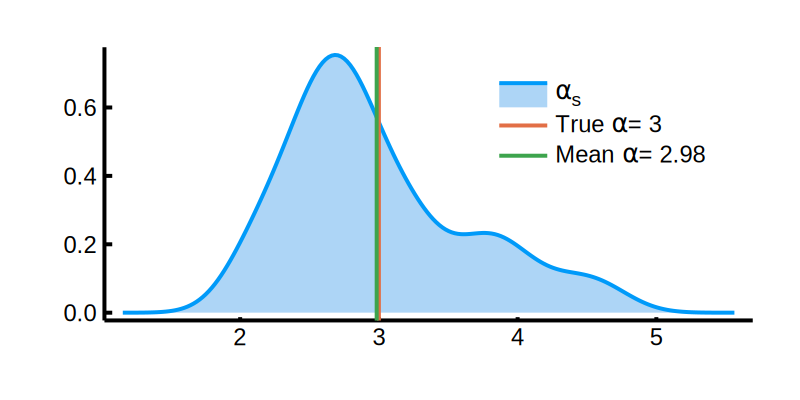

In [8]:
# α
fig = density(params_sim[:, :α], fill=(0, .5,:steelblue2), lab="\\alpha_s",  
        linecolor=:match, linewidth=1)
plot!(collect(α), seriestype="vline", 
        lab="True \\alpha = " * string(α), 
        linewidth=1)
plot!(collect(mean(params_sim.α)), seriestype="vline", 
        lab="Mean \\alpha = " * string(round(mean(params_sim.α), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_3_alpha.png")
fig

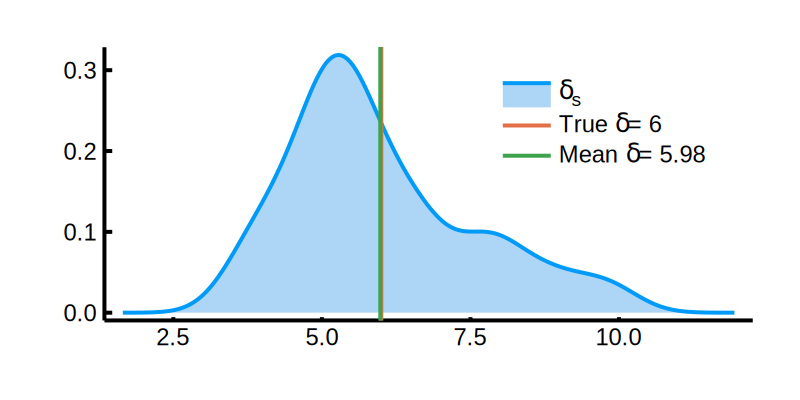

In [9]:
# δ
fig = density(params_sim[:, :δ], fill=(0, .5,:steelblue2), lab="\\delta_s",  
        linecolor=:match, linewidth=1)
plot!(collect(δ), seriestype="vline", 
        lab="True \\delta = " * string(δ), 
        linewidth=1)
plot!(collect(mean(params_sim.δ)), seriestype="vline", 
        lab="Mean \\delta = " * string(round(mean(params_sim.δ), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_3_delta.png");
fig

<br><br><br><br><br>

### 1.3.4 - All-Strategies Estimation

We now allow the equilibria to be chosen randomly (the firms know the strategy that is chosen, but we do not).

##### Generate data

In [10]:
# Model k ∈ {1,...,K} with prob exp(k/2)
eq_opts = eq_vec[:,2]
eq_probs = exp.([1, 2, 3]./2) ./ sum(exp.([1, 2, 3]./2))

# Function to map x, equilibrium, and player number to other player's strat
eq_map = function(x, eq, player)
    x = convert(Int64, x)
    return eq_opts[x][eq,player]
end

# Set up parameters
α=3; δ=6
T=1000; S=50

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
#dt.x = rand(Binomial(1,0.5), S*T) .+ Ref(1.0) # Testing with drawing x each iteration - - - - - - - - - - - - 
dt.ϵ_1 = rand(Logistic(0,1), S*T)
dt.ϵ_2 = rand(Logistic(0,1), S*T)
dt.eq = rand(Categorical(eq_probs), S*T)
dt.y_1 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 2) .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 1) .+ dt.ϵ_2 .>= 0);

First, we can check how the MLE estimator from the previous section performs:

In [11]:
# Loop over simulation draws
params_sim = DataFrame(α= fill(0.0, S), δ= fill(0.0, S))
print("Iters: ")
for s in 1:nrow(params_sim)
    dt_sim = copy(dt[dt[:s].==s,:]);
    # res = optimize(ll_optim, [1.0, 1.0])
    res = optimize(ll_optim, ll_grad_optim, [1.0,1.0], BFGS())
    params_sim[s, [:α, :δ]] = res.minimizer
    print(" " * string(s))
end
params_sim_1_4_sym = params_sim

println(" "); println(" ")
println("Mean α is " * string(mean(params_sim.α)) * "Var of α is " * string(std(params_sim.α)^2))
println("Mean δ is " * string(mean(params_sim.δ)) * "Var of δ is " * string(std(params_sim.δ)^2))

Iters:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 
Mean α is 2.9621510610217467Var of α is 0.27799518362239517
Mean δ is 5.9686816772744695Var of δ is 1.5208707312736431


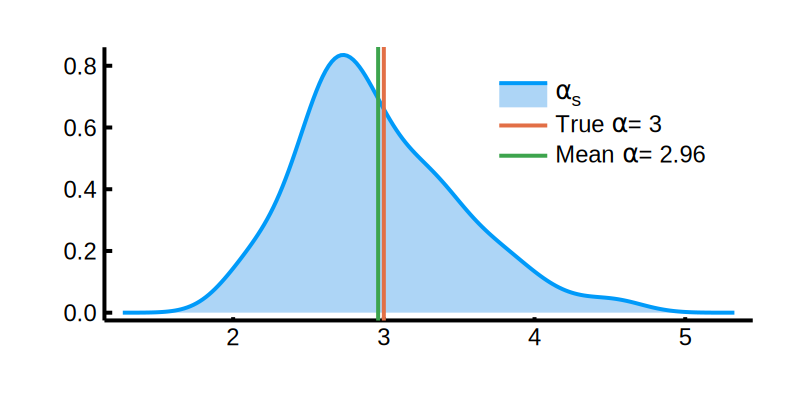

In [12]:
# α
fig = density(params_sim[:, :α], fill=(0, .5,:steelblue2), lab="\\alpha_s",  
        linecolor=:match, linewidth=1)
plot!(collect(α), seriestype="vline", 
        lab="True \\alpha = " * string(α), 
        linewidth=1)
plot!(collect(mean(params_sim.α)), seriestype="vline", 
        lab="Mean \\alpha = " * string(round(mean(params_sim.α), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4sym_alpha.png")
fig

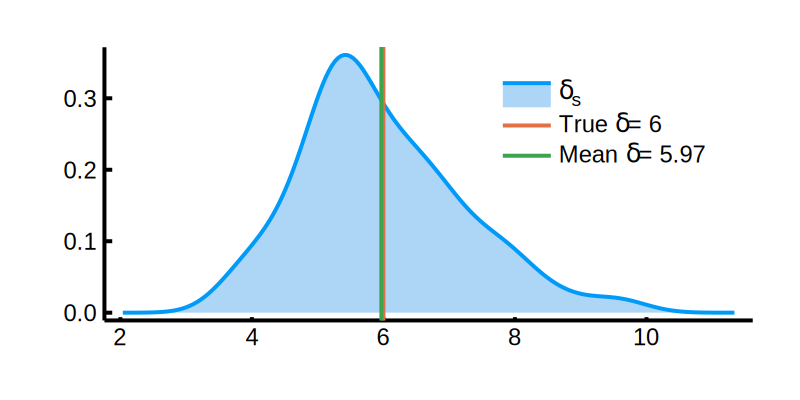

In [13]:
# δ
fig = density(params_sim[:, :δ], fill=(0, .5,:steelblue2), lab="\\delta_s",  
        linecolor=:match, linewidth=1)
plot!(collect(δ), seriestype="vline", 
        lab="True \\delta = " * string(δ), 
        linewidth=1)
plot!(collect(mean(params_sim.δ)), seriestype="vline", 
        lab="Mean \\delta = " * string(round(mean(params_sim.δ), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4sym_delta.png");
fig

##### Estimating with random equilibria

# EM-ALGORITHM?

We consider mixture weights $\omega_i$ as auxiliary parameters for $i \in \{1,2,3\}$

##### Functions for log-likelihood evaluation to determine convergence

In [14]:
# Adjust weights to ensure bounds work
ω_bound(ω,i) = exp(ω[i]) / (sum(exp.(ω)));

In [15]:
# Likelihood individual term
l_mix_i = function(; α, δ, x, p, y)
    y1 = br_eq_vec(α=α, δ=δ, x=x, p=p).^y
    y0 = (Ref(1.0) .- br_eq_vec(α=α, δ=δ, x=x, p=p)).^(Ref(1.0) .- y)
    return y1 .* y0
end

# Log-Likelihood function for mixture
ll_mix_all = function(; α, δ, ω=[1/3, 1/3, 1/3])
    dt_temp = copy(dt_sim); 
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob_eq1 =  ω_bound(ω,1).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2)
    prob_eq2 =  ω_bound(ω,2).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2)
    prob_eq3 =  ω_bound(ω,3).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2)
    prob = log.(prob_eq1 .+ prob_eq2 .+ prob_eq3)
    return sum(prob)
end

# Adapt Log-Likelihood to pass to Optim
ll_mix_optim = function(θ)
    α=θ[1]; δ=θ[2]; ω=θ[3:5]
    return -1.0 .* ll_mix_all(α=α, δ=δ, ω=ω)
end;

We now check to make sure this is working properly for some values of $\theta$.

In [16]:
dt_sim = copy(dt[dt[:s].==1,:]);
ll_mix_optim([3.0,6.0,1/3,1/3,1/3])

1166.2915147615338

In [17]:
ll_mix_optim([3.0,6.0,0.2,0.3,0.5])

1153.673567696966

In [18]:
ll_mix_optim([1.0,1.0,0.2,0.3,0.5])

1247.2589389340085

##### Functions for EM algorithm to estimate the parameters

In [21]:
# Expected log-likelihood function
E_ll_mix_all = function(; α, δ, ω, z_weights)
    dt_temp = copy(dt_sim); 
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob1 = z_weights[:,1].*(log.(ω_bound(ω,1)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1)) .+
            z_weights[:,2].*(log.(ω_bound(ω,2)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1)) .+
            z_weights[:,3].*(log.(ω_bound(ω,3)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1))
    prob2 = z_weights[:,1].*(log.(ω_bound(ω,1)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2)) .+
            z_weights[:,2].*(log.(ω_bound(ω,2)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2)) .+
            z_weights[:,3].*(log.(ω_bound(ω,3)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2))
    prob = prob1 .+ prob2
    return sum(prob)
end


# EM iteration
em_step = function(; θ, iters=100, trace_on=false)
    α=θ[1]; δ=θ[2]; ω=θ[3:5];
    dt_temp = copy(dt_sim); 
    
    
    # Likelihood of each observation's equilibrium given parameter values (E step)
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob_eq1 =  ω_bound(ω,1).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2)
    prob_eq2 =  ω_bound(ω,2).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2)
    prob_eq3 =  ω_bound(ω,3).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2)
    probs = hcat(prob_eq1, prob_eq2, prob_eq3)
    p_rowsum = sum(probs, dims=2)
    z_weights = probs ./ hcat(p_rowsum, p_rowsum, p_rowsum)
    
    # Maximize likelihood given weights (M step)
    ω_mle = mean(z_weights, dims=1)
    ω_mle ./ sum(ω_mle)
        # Adapt E[Log-Likelihood] to pass to Optim
        E_ll_mix_optim = function(θ)
            α=θ[1]; δ=θ[2];
            return -1.0 .* E_ll_mix_all(α=α, δ=δ, ω=ω_mle, z_weights=z_weights)
        end;
    optimum_g = optimize(E_ll_mix_optim, θ[1:2], Optim.Options(show_trace = trace_on, iterations=iters))
    θ = optimum_g.minimizer
    θ = vcat(θ, ω_mle')
    return θ
end


# Implement EM algorithm
em_alg = function(; θ_0, iters_step=100, lik_trace_on=false, em_trace_on=false, ϵ_conv=1e-6, maxiter=10000)
    diff = 1; ll_0 = 0; iter = 1
    while (diff > ϵ_conv) & (iter < maxiter)
        θ_1 = em_step(θ=θ_0, iters=iters_step, trace_on=lik_trace_on)
        ll_1 = ll_mix_optim(θ_1)
        diff = abs(ll_1 - ll_0)
        θ_0 = θ_1; ll_0 = ll_1; iter = iter + 1
        if em_trace_on == true
            println("Log-likelihood is " * string(round(ll_1, digits=4)))
            println("    θ is " * string(round.(θ_0, digits=4)))
        end
    end
    return θ_0
end;

First, test the EM algorithm function for reasonably far values of $\theta$ (particularly $\alpha$ and $\delta$) and uniform prior on the equilibria:

In [56]:
em_alg(θ_0 = [1.0,2.0, 1/3,1/3,1/3], iters_step=10, lik_trace_on=false, em_trace_on=true, ϵ_conv=1e-5)

Log-likelihood is 1230.7892
    θ is [1.3925; 2.3221; 0.3333; 0.3333; 0.3333]
Log-likelihood is 1225.2246
    θ is [2.0941; 3.8069; 0.3333; 0.3333; 0.3333]
Log-likelihood is 1224.8935
    θ is [2.1384; 3.9267; 0.3333; 0.3333; 0.3333]
Log-likelihood is 1224.7927
    θ is [2.0644; 3.8423; 0.3333; 0.3333; 0.3333]
Log-likelihood is 1224.7927
    θ is [2.0644; 3.8423; 0.3333; 0.3333; 0.3333]


5×1 Array{Float64,2}:
 2.06437734907728
 3.8422763995015674
 0.3333333333333332
 0.3333333333333329
 0.333333333333333

While the $\alpha$ and $\delta$ values start approaching their true value initially, they do not change much with the EM iterations, and the weights do not change much, either.  Testing a few parameter values and starting points reveals that this algorithm can be very slow to converge, and there are many relatively flat spots (so the algorithm gets stuck away from the true parameter values before fine-tuning the weights).  To work around this, we search for different starting points and then let the algorithm work from there.

##### Function to search starting points for EM algorithm

In [75]:
em_alg_search = function(; α_low=1.5, α_high=6.5, δ_low=2.5, δ_high=7.5, α_steps=6, δ_steps=6,
            ω_start=[1/3,1/3,1/3], trace=false)
    # Set up search
    αδ_grid = [[α,δ] for α in LinRange(α_low,α_high,α_steps) for δ in LinRange(δ_low,δ_high,δ_steps)]
    for r in 1:length(αδ_grid)
        αδ_grid[r] = vcat(αδ_grid[r], ω_start)
    end
    
    # EM search for starting value
    θ_grid = αδ_grid
    ll_store = fill(Inf, length(θ_grid))
    θ_store = θ_grid
    for r in 1:length(θ_grid)
        ll_store[r] = ll_mix_optim(θ_grid[r])
    end
    start_index = findmin(ll_store)[2]
    if trace==true
        println(" New starting value is " * string(θ_store[start_index]) * 
                " with LL = " * string(ll_store[start_index]))
    end
        
    # EM from best starting value
    θ_opt = em_alg(θ_0 = θ_store[start_index], iters_step=10, ϵ_conv=1e-4)
    return θ_opt
end;

In [76]:
em_alg_search(trace=true)

 New starting value is [3.5, 6.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333] with LL = 1165.68237328536


5×1 Array{Float64,2}:
 2.92766597493653
 5.79890577254537
 0.2830489219975266
 0.3254800296267972
 0.3914710483756762

##### Test with simulation data

In [77]:
# Loop over simulation draws
params_sim = DataFrame(α= fill(0.0, S), δ= fill(0.0, S))
print("Iters: ")
for s in 1:nrow(params_sim)
    dt_sim = copy(dt[dt[:s].==s,:]);
    # res = optimize(ll_optim, [1.0, 1.0])
    res = em_alg_search(α_low=1.0, α_high=5.0, δ_low=3.0, δ_high=7.0, α_steps=10, δ_steps=10,
                        ω_start=[1/3,1/3,1/3])
    params_sim[s, [:α, :δ]] = res[1:2]
    print(" " * string(s))
end
params_sim_1_4_asym = params_sim

println(" "); println(" ")
println("Mean α is " * string(mean(params_sim.α)) * "Var of α is " * string(std(params_sim.α)^2))
println("Mean δ is " * string(mean(params_sim.δ)) * "Var of δ is " * string(std(params_sim.δ)^2))

Iters:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 
Mean α is 3.4624981314446854Var of α is 0.014223737465120592
Mean δ is 6.665563666668795Var of δ is 0.03730721626403787


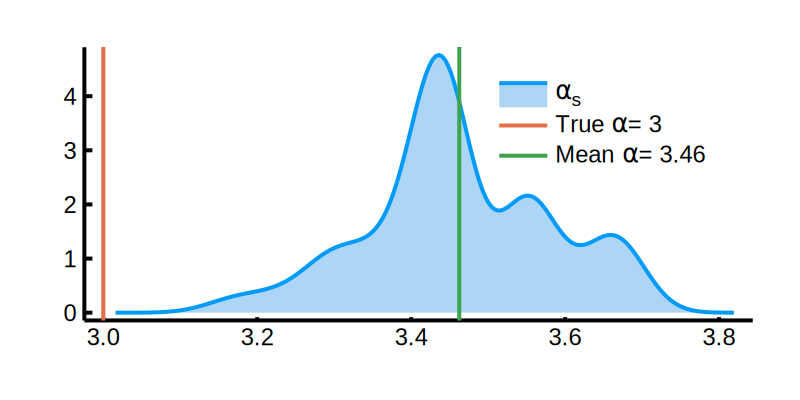

In [78]:
# α
fig = density(params_sim[:, :α], fill=(0, .5,:steelblue2), lab="\\alpha_s",  
        linecolor=:match, linewidth=1)
plot!(collect(α), seriestype="vline", 
        lab="True \\alpha = " * string(α), 
        linewidth=1)
plot!(collect(mean(params_sim.α)), seriestype="vline", 
        lab="Mean \\alpha = " * string(round(mean(params_sim.α), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4asym_alpha.png")
fig

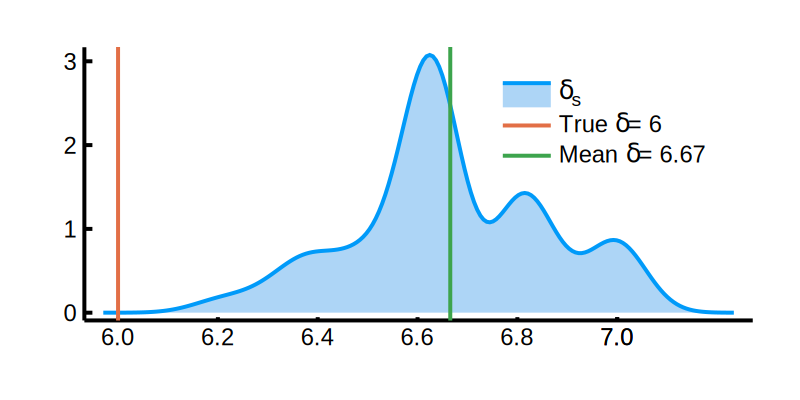

In [79]:
# δ
fig = density(params_sim[:, :δ], fill=(0, .5,:steelblue2), lab="\\delta_s",  
        linecolor=:match, linewidth=1)
plot!(collect(δ), seriestype="vline", 
        lab="True \\delta = " * string(δ), 
        linewidth=1)
plot!(collect(mean(params_sim.δ)), seriestype="vline", 
        lab="Mean \\delta = " * string(round(mean(params_sim.δ), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4asym_delta.png");
fig

<br><br><br><br>

### 1.3.5 More unobserved heterogeneity

In [33]:
# Model k ∈ {1,...,K} with prob exp(k/2)
eq_opts = eq_vec[:,2]

# Function to map x, equilibrium, and player number to other player's strat
eq_map = function(x, eq, player)
    x = convert(Int64, x)
    return eq_opts[x][eq,player]
end

# Set up parameters
α=3; δ=6
T=1000; S=50

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
dt.ϵ_1 = rand(Logistic(0,1), S*T)
dt.ϵ_2 = rand(Logistic(0,1), S*T)
dt.eq = Ref(0)
for r in 1:nrow(dt)
    u_p = 1.0 ./(1.0 .+ dt[r,:x])
    num = [1.0, 2.0, 3.0] .+ repeat(1.0.* rand(Binomial(1, 0.5),1),3)
    eq_probs = exp.(num./2) ./ sum(exp.(num./2))
    dt.eq = rand(Categorical(eq_probs), 1)[1]
end
dt.y_1 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 2) .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 1) .+ dt.ϵ_1 .>= 0);

Now we estimate this with the same method as above:

For comparison, we estimate this with the method in question 1.3.3:

<br><br><br><br>

## QUESTION 2.3

##### Read in data

In [34]:
data = CSV.read("psetTwo.csv", DataFrame);
println(names(data))
convert.(Float64, data.milage);

["milage"]


##### Define utility function

In [35]:
utility = function(; x, d, θ)
    if d == 0
        return -θ[1].*x .- θ[2].*(x./100).^2
    else
        return -θ[3]
    end
end;

<br><br>
### 1. Engine replacement

Generate dummy variable.

In [36]:
data.d = 1.0.*(data[:milage] .< lag(data[:milage]));
data[ismissing.(data[:d]),:d] = Ref(0.0);

<br><br>
### 3. Discretize state space and estimate transition probabilities

##### Discretize state space and generate state dummy variables

In [37]:
# Get summary statistics of milage
min_mile = minimum(data.milage)
max_mile = maximum(data.milage)
println(minimum(data.milage))
println(maximum(data.milage))

1
221


In [38]:
# Divide state space into K states
K = 21;

### Using constant step sizes

In [39]:
# k_step = (max_mile - min_mile)/K

# state_cols = fill(" ", K)
# for k in 1:K
#     k_min = min_mile + (k-1)*k_step
#     k_max = min_mile + k*k_step
#     data[!, "s_" * string(k)] = 1.0.*(k_min .≤ data.milage .≤ k_max)
#     state_cols[k] = "s_" * string(k)
# end

### Using (approximately) constant bin counts

In [40]:
k_q = nquantile(data.milage, K);
data.s_now = Ref(0)

state_cols = fill(" ", K)
last_state_cols = fill(" ", K)
for k in 1:K
    data[(k_q[k] .< data.milage .≤ k_q[k+1]) .| (data.milage .== 1), :s_now] = Ref(k)
end

## From here on, no dependence on how state chunks were set

In [41]:
data.s_prev = Ref(0)
for r in 2:nrow(data)
    data[r,:s_prev] = data[r-1,:s_now]
end

In [42]:
for k in 1:K
    data[!, "s_" * string(k)] = 1.0.*(data.s_now .== k)
    state_cols[k] = "s_" * string(k)
end
for k in 1:K
    data[!, "ls_" * string(k)] = 1.0.*(data.s_prev .== k)
    last_state_cols[k] = "ls_" * string(k)
end

##### Estimate conditional transition probabilities

Start with transition probability conditional on $d=1$.

In [43]:
# Estimate P_d1
P_d1 = reshape(fill(0.0,K*K), K, K);
for k in 1:K
    if nrow(data[(data[:d] .== 1) .& (data[:s_prev] .== k),:]) > 0
        row_k = mean(Matrix(data[(data.d .== 1) .& (data.s_prev .== k), state_cols]), dims=1)
        P_d1[k,:] = row_k
    end
end

In [44]:
round.(P_d1,digits=1)

21×21 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.3  0.3  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.3  0.3  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.5  0.0  0.0  0.0  0.0  

Now estimate transition probability conditional on $d=0$.

In [45]:
# Estimate P_d1
P_d0 = reshape(fill(0.0,K*K), K, K);
for k in 1:K
    if nrow(data[(data[:d] .== 0) .& (data[:s_prev] .== k),:]) > 0
        row_k = mean(Matrix(data[(data.d .== 0) .& (data.s_prev .== k), state_cols]), dims=1)
        P_d0[k,:] = row_k
    end
end

In [46]:
round.(P_d0,digits=1)

21×21 Array{Float64,2}:
 0.1  0.5  0.3  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.4  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.4  0.3  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.3  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.4  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.4  0.4  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  

<br><br>
### 3. Fixed-point solver with Rust's poly-algorithm

<br><br>
### 4. Compute Likelihood

<br><br>
### 5. Compute Likelihood gradient

<br><br>
### 6. Estimation

<br><br><br><br>

## QUESTION 2.3.2

### 3. Non-parametric estimation of CCPs

### 4. Sequential policy estimation

### 5. Solving estimator once

### 6. Solving estimator 10 times

<br><br><br><br>

## QUESTION 2.3.3

### 1. Forward simulation for value function

### 2. Hotz-Miller inversion

### 3. BBL loss function

### 4. Frequency estimator

### 5. Estimation